In [7]:
import pandas as pd
file_path = 'datasetkdd.csv'
df = pd.read_csv(file_path)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [8]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, chi2
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=['class'])
y = df['class']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()
for col in categorical_features:
    X[col] = label_encoder.fit_transform(X[col])

scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Onehot encode categorical features 
X_categorical = pd.get_dummies(X, drop_first=True)  

# Mutual Information Scores
mi_scores = mutual_info_classif(X, y_encoded, random_state=0)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)

# Chi-Square Test Scores
chi2_scores, p_values = chi2(X_categorical, y_encoded)  # Use one-hot encoded features
chi2_scores = pd.Series(chi2_scores, index=X_categorical.columns).sort_values(ascending=False)
print("\nChi-Square Test Scores:")
print(chi2_scores)

combined_scores = mi_scores.add(chi2_scores, fill_value=0)  
combined_scores = combined_scores.sort_values(ascending=False)

top_8_features = combined_scores.index[:8]
print("\nTop 8 features based on combined Mutual Information and Chi-Square scores:")
print(top_8_features)
X_top_8 = X[top_8_features]

plt.figure(figsize=(10, 8))
corr_matrix = X_top_8.corr()
#plt.title("Correlation Matrix - Top 8 Features")
plt.show()
threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

final_selected_features = top_8_features.drop(to_drop)
print("\nFinal selected features after removing correlated ones:")
print(final_selected_features)

selected_list = final_selected_features.tolist()
print("\nFeatures selected for training:")
print(selected_list)

final_chi2_scores = chi2_scores[final_selected_features]
print("\nChi-Square scores for the final selected features:")
print(final_chi2_scores)



Mutual Information Scores:
src_bytes                      0.542678
dst_bytes                      0.437492
service                        0.434002
flag                           0.338065
same_srv_rate                  0.328913
diff_srv_rate                  0.320513
dst_host_srv_count             0.302225
dst_host_same_srv_rate         0.278945
logged_in                      0.264642
dst_host_diff_srv_rate         0.259576
dst_host_serror_rate           0.239895
serror_rate                    0.235771
count                          0.234296
dst_host_srv_serror_rate       0.232838
srv_serror_rate                0.223356
dst_host_srv_diff_host_rate    0.173179
dst_host_count                 0.137067
dst_host_same_src_port_rate    0.129467
srv_diff_host_rate             0.098674
dst_host_srv_rerror_rate       0.064341
rerror_rate                    0.055661
protocol_type                  0.054081
dst_host_rerror_rate           0.052164
srv_rerror_rate                0.052009
srv_count   

<Figure size 1000x800 with 0 Axes>


Final selected features after removing correlated ones:
Index(['service', 'flag', 'logged_in', 'dst_host_srv_serror_rate',
       'dst_host_srv_count'],
      dtype='object')

Features selected for training:
['service', 'flag', 'logged_in', 'dst_host_srv_serror_rate', 'dst_host_srv_count']

Chi-Square scores for the final selected features:
service                     111750.974116
flag                         65087.683360
logged_in                    39119.530488
dst_host_srv_serror_rate     38464.712814
dst_host_srv_count           28933.402371
dtype: float64


In [9]:
selected_features = ['service', 'flag', 'logged_in', 'dst_host_srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate', 'count', 'rerror_rate']

X = df[selected_features].copy()
y = df['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

label_encoder = LabelEncoder()
X['flag'] = label_encoder.fit_transform(X['flag'])
X['service'] = label_encoder.fit_transform(X['service'])
X['class'] = y
print("\n after preprocessing")
X.head() 


 after preprocessing


,service,flag,logged_in,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,count,rerror_rate,class
0,20,9,0,0.00,25.0,1.00,2.0,0.0,0
1,44,9,0,0.00,1.0,0.08,13.0,0.0,0
2,49,5,0,1.00,26.0,0.05,123.0,0.0,1
3,24,9,1,0.01,255.0,1.00,5.0,0.0,0
4,24,9,1,0.00,255.0,1.00,30.0,0.0,0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='class'), y, test_size=0.2, random_state=42)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled training features:")
X_train_scaled.head()


Scaled training features:


,service,flag,logged_in,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,count,rerror_rate
0,1.369035,0.734424,1.218479,-0.584729,0.417703,0.749724,-0.706007,-0.406978
1,-0.473384,0.734424,1.218479,-0.584729,1.217821,0.749724,-0.706007,-0.406978
2,1.369035,0.734424,1.218479,-0.584729,1.127920,0.749724,-0.706007,-0.406978
3,-1.640249,-0.706387,-0.820695,1.742244,-0.921821,-1.494273,1.162639,-0.406978
4,0.509240,-0.706387,-0.820695,1.742244,-1.056672,-1.517171,1.265500,-0.406978


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_model(input_shape):
    model = keras.Sequential()
    
    #first hidden layer
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    return model

input_shape = (X_train_scaled.shape[1],)  
model = create_model(input_shape)

# Compile model
model.compile(optimizer='sgd',              # Stochastic Gradient Descent
              loss='binary_crossentropy',  
              metrics=['accuracy'])        



c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# model Training
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.3,  
                    epochs=10,           
                    batch_size=32,         
                    verbose=1)            


Epoch 1/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8561 - loss: 0.3210 - val_accuracy: 0.8868 - val_loss: 0.2449
Epoch 2/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8867 - loss: 0.2401 - val_accuracy: 0.8935 - val_loss: 0.2310
Epoch 3/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8985 - loss: 0.2277 - val_accuracy: 0.8979 - val_loss: 0.2221
Epoch 4/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9001 - loss: 0.2197 - val_accuracy: 0.9015 - val_loss: 0.2154
Epoch 5/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9063 - loss: 0.2119 - val_accuracy: 0.9106 - val_loss: 0.2100
Epoch 6/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9090 - loss: 0.2105 - val_accuracy: 0.9119 - val_loss: 0.2063
Epoch 7/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9133 - loss: 0.2041 - val_accuracy: 0.9137 - val_loss: 0.2035
Epoch 8/10
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9142 - loss: 0.2004 - 

Epoch 1/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9157 - loss: 0.1958 - val_accuracy: 0.9143 - val_loss: 0.1957
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9165 - loss: 0.1930 - val_accuracy: 0.9158 - val_loss: 0.1932
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9167 - loss: 0.1919 - val_accuracy: 0.9158 - val_loss: 0.1912
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9176 - loss: 0.1896 - val_accuracy: 0.9169 - val_loss: 0.1891
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9205 - loss: 0.1856 - val_accuracy: 0.9178 - val_loss: 0.1879
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9207 - loss: 0.1833 - val_accuracy: 0.9165 - val_loss: 0.1863
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9192 - loss: 0.1850 - val_accuracy: 0.9187 - val_loss: 0.1839
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9217 - loss: 0.1807 - 

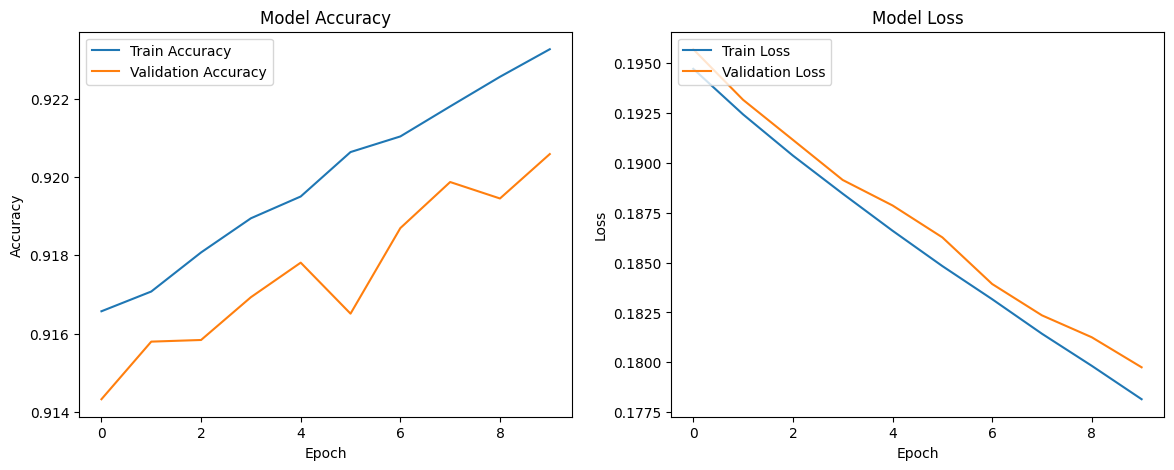

In [14]:
# Train the model with specified parameters
epochs = 10  
batch_size = 32  

history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2,  
                    epochs=epochs,         
                    batch_size=batch_size,  
                    verbose=1)            

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


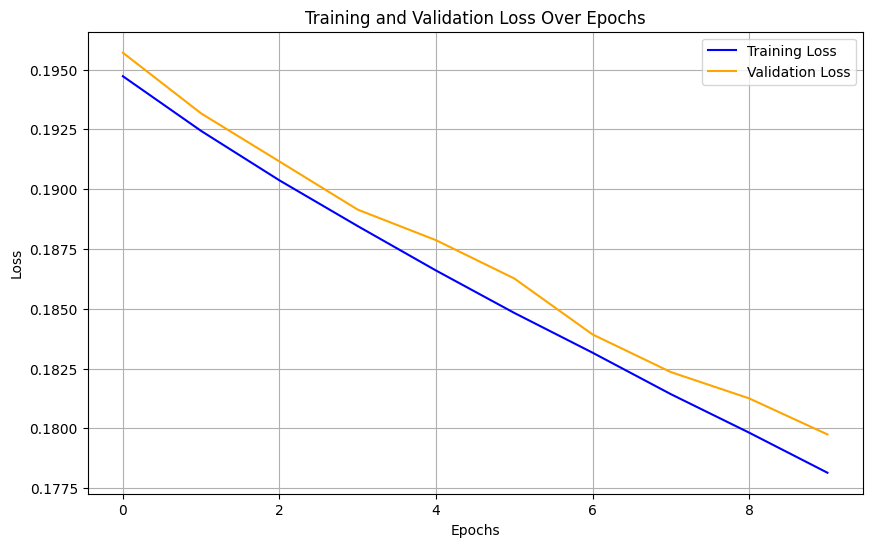

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [16]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.17900450527668
Test Accuracy: 0.9226366877555847


929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


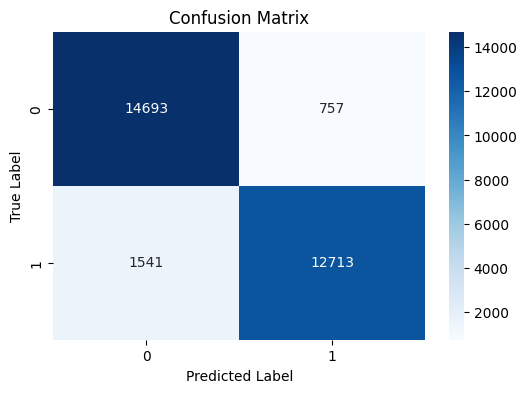

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)  

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.95      0.93     15450
   Malicious       0.94      0.89      0.92     14254

    accuracy                           0.92     29704
   macro avg       0.92      0.92      0.92     29704
weighted avg       0.92      0.92      0.92     29704




Training with learning rate: 0.001
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8223 - loss: 0.4843 - val_accuracy: 0.8710 - val_loss: 0.2934
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8735 - loss: 0.2802 - val_accuracy: 0.8739 - val_loss: 0.2638
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8732 - loss: 0.2608 - val_accuracy: 0.8749 - val_loss: 0.2541
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8768 - loss: 0.2519 - val_accuracy: 0.8788 - val_loss: 0.2477
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8819 - loss: 0.2433 - val_accuracy: 0.8822 - val_loss: 0.2429
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8829 - loss: 0.2404 - val_accuracy: 0.8852 - val_loss: 0.2390
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8872 - loss: 0.2361 - val_accuracy: 0.8872 - val_loss: 0.2356
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8899 - loss: 0.2315 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8721 - loss: 0.2900 - val_accuracy: 0.8908 - val_loss: 0.2283
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8977 - loss: 0.2204 - val_accuracy: 0.9085 - val_loss: 0.2123
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9124 - loss: 0.2071 - val_accuracy: 0.9129 - val_loss: 0.2030
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9169 - loss: 0.1962 - val_accuracy: 0.9182 - val_loss: 0.1940
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9208 - loss: 0.1898 - val_accuracy: 0.9203 - val_loss: 0.1873
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9229 - loss: 0.1828 - val_accuracy: 0.9232 - val_loss: 0.1815
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9231 - loss: 0.1787 - val_accuracy: 0.9243 - val_loss: 0.1766
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9264 - loss: 0.1729 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8963 - loss: 0.2293 - val_accuracy: 0.9163 - val_loss: 0.1832
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9271 - loss: 0.1722 - val_accuracy: 0.9331 - val_loss: 0.1562
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9411 - loss: 0.1513 - val_accuracy: 0.9501 - val_loss: 0.1343
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9512 - loss: 0.1353 - val_accuracy: 0.9561 - val_loss: 0.1247
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9538 - loss: 0.1254 - val_accuracy: 0.9370 - val_loss: 0.1899
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9559 - loss: 0.1205 - val_accuracy: 0.9579 - val_loss: 0.1152
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9557 - loss: 0.1192 - val_accuracy: 0.9587 - val_loss: 0.1188
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9566 - loss: 0.1176 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9045 - loss: 0.2119 - val_accuracy: 0.9478 - val_loss: 0.1438
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9485 - loss: 0.1446 - val_accuracy: 0.9576 - val_loss: 0.1243
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9554 - loss: 0.1284 - val_accuracy: 0.9417 - val_loss: 0.1448
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9560 - loss: 0.1231 - val_accuracy: 0.9562 - val_loss: 0.1271
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9571 - loss: 0.1208 - val_accuracy: 0.9587 - val_loss: 0.1214
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9598 - loss: 0.1137 - val_accuracy: 0.9592 - val_loss: 0.1129
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9597 - loss: 0.1124 - val_accuracy: 0.9561 - val_loss: 0.1181
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9593 - loss: 0.1146 - val_accurac

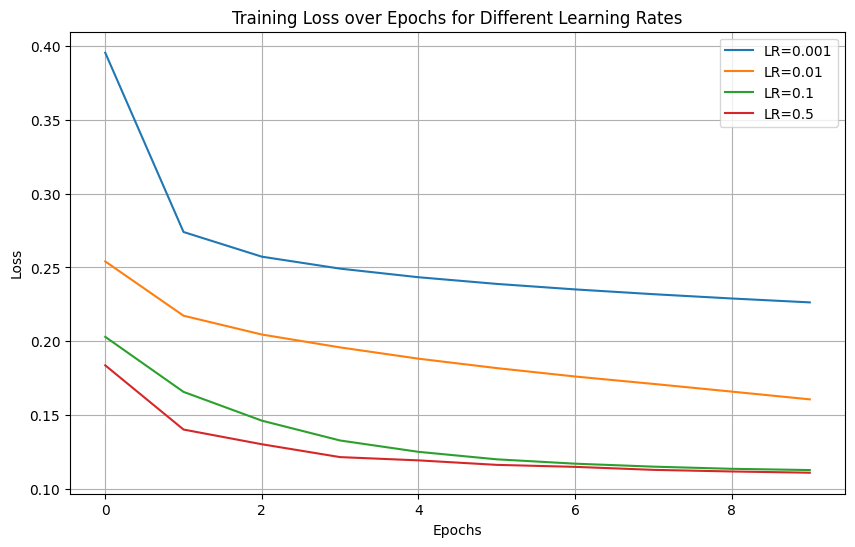

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt


input_shape = (X_train_scaled.shape[1],)  

def create_model_with_lr(input_shape, learning_rate):
    model = Sequential()  
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) 
    optimizer = SGD(learning_rate=learning_rate)  
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

learning_rates = [0.001, 0.01, 0.1, 0.5]

history_dict = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = create_model_with_lr(input_shape, learning_rate=lr)
    history = model.fit(X_train_scaled, y_train, 
                        validation_split=0.2, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)
    
    history_dict[lr] = history.history['loss']

    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy with learning rate {lr}: {test_accuracy}")

plt.figure(figsize=(10, 6))
for lr, loss in history_dict.items():
    plt.plot(loss, label=f'LR={lr}')
    
plt.title('Training Loss over Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Training with optimizer: sgd
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8624 - loss: 0.3217 - val_accuracy: 0.8926 - val_loss: 0.2306
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9001 - loss: 0.2201 - val_accuracy: 0.9016 - val_loss: 0.2131
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9061 - loss: 0.2098 - val_accuracy: 0.9073 - val_loss: 0.2032
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9127 - loss: 0.2007 - val_accuracy: 0.9149 - val_loss: 0.1954
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9189 - loss: 0.1905 - val_accuracy: 0.9180 - val_loss: 0.1883
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9209 - loss: 0.1845 - val_accuracy: 0.9189 - val_loss: 0.1834
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9224 - loss: 0.1813 - val_accuracy: 0.9214 - val_loss: 0.1798
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9256 - loss: 0.1758 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9048 - loss: 0.2233 - val_accuracy: 0.9343 - val_loss: 0.1589
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9430 - loss: 0.1489 - val_accuracy: 0.9545 - val_loss: 0.1311
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9565 - loss: 0.1275 - val_accuracy: 0.9550 - val_loss: 0.1238
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9580 - loss: 0.1198 - val_accuracy: 0.9582 - val_loss: 0.1192
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9589 - loss: 0.1166 - val_accuracy: 0.9580 - val_loss: 0.1173
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9593 - loss: 0.1135 - val_accuracy: 0.9590 - val_loss: 0.1110
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9608 - loss: 0.1089 - val_accuracy: 0.9588 - val_loss: 0.1177
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9608 - loss: 0.1081 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8955 - loss: 0.2332 - val_accuracy: 0.9324 - val_loss: 0.1656
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9367 - loss: 0.1567 - val_accuracy: 0.9543 - val_loss: 0.1405
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9533 - loss: 0.1348 - val_accuracy: 0.9579 - val_loss: 0.1327
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9574 - loss: 0.1239 - val_accuracy: 0.9590 - val_loss: 0.1206
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9594 - loss: 0.1209 - val_accuracy: 0.9444 - val_loss: 0.1320
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9588 - loss: 0.1216 - val_accuracy: 0.9528 - val_loss: 0.1255
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9596 - loss: 0.1194 - val_accuracy: 0.9544 - val_loss: 0.1262
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9586 - loss: 0.1215 - val_accurac

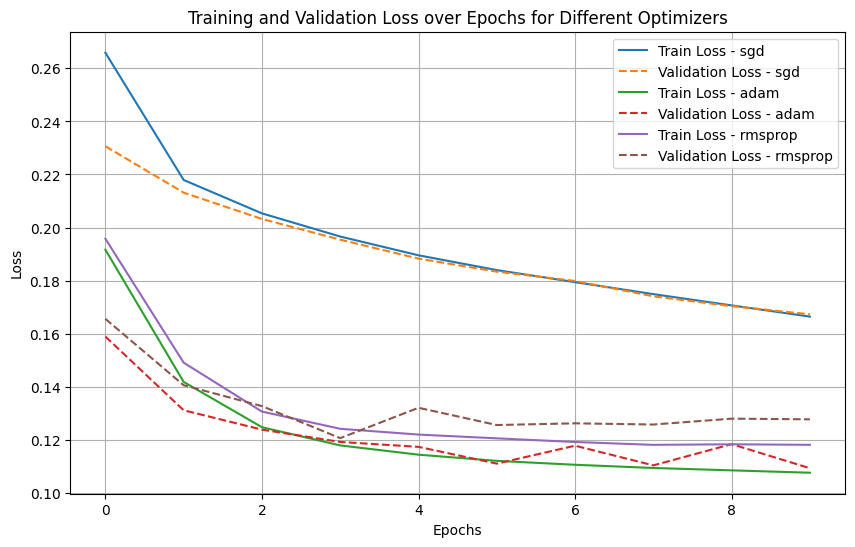

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

input_shape = (X_train_scaled.shape[1],)  

def create_model_with_optimizer(input_shape, optimizer_name):
    model = Sequential()  
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam()
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop()
    else:
        optimizer = tf.keras.optimizers.SGD()  
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

optimizers = ['sgd', 'adam', 'rmsprop']
history_dict = {}

for opt in optimizers:
    print(f"\nTraining with optimizer: {opt}")
    model = create_model_with_optimizer(input_shape, optimizer_name=opt)
    history = model.fit(X_train_scaled, y_train, 
                        validation_split=0.2, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)
    
    history_dict[opt] = {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }

    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy with optimizer {opt}: {test_accuracy}")

plt.figure(figsize=(10, 6))

for opt, losses in history_dict.items():
    plt.plot(losses['loss'], label=f'Train Loss - {opt}')
    plt.plot(losses['val_loss'], linestyle='--', label=f'Validation Loss - {opt}')

plt.title('Training and Validation Loss over Epochs for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Training with an extra hidden layer
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9046 - loss: 0.2286 - val_accuracy: 0.9443 - val_loss: 0.1512
Epoch 2/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9491 - loss: 0.1384 - val_accuracy: 0.9575 - val_loss: 0.1201
Epoch 3/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9563 - loss: 0.1204 - val_accuracy: 0.9591 - val_loss: 0.1157
Epoch 4/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9590 - loss: 0.1145 - val_accuracy: 0.9577 - val_loss: 0.1176
Epoch 5/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9595 - loss: 0.1113 - val_accuracy: 0.9596 - val_loss: 0.1114
Epoch 6/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9580 - loss: 0.1107 - val_accuracy: 0.9589 - val_loss: 0.1129
Epoch 7/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9593 - loss: 0.1100 - val_accuracy: 0.9584 - val_loss: 0.1110
Epoch 8/10
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9601 - loss: 0.1076 - val_accurac

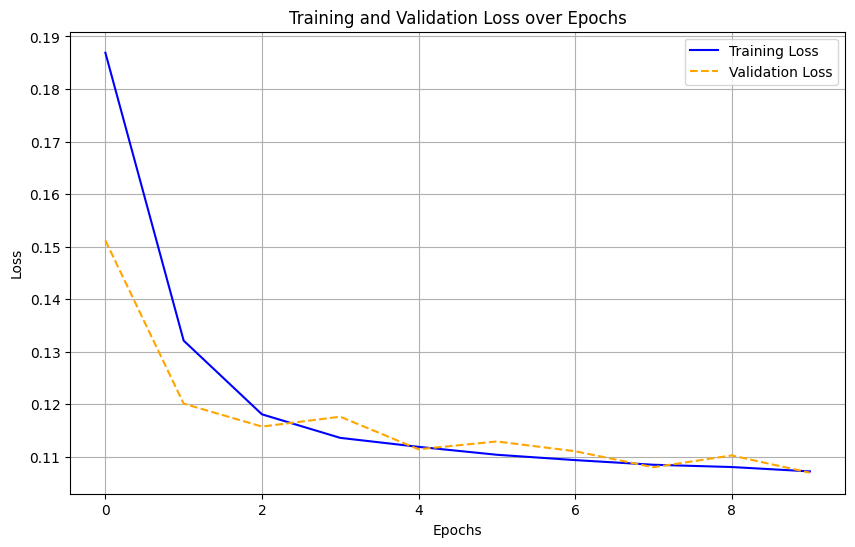

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

input_shape = (X_train_scaled.shape[1],)  

def create_model_with_extra_layer(input_shape):
    model = Sequential()  
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam() 
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

print("\nTraining with an extra hidden layer")
model = create_model_with_extra_layer(input_shape)
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy with extra hidden layer: {test_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
